# Project Description

The company Sweet Lift Taxi has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the number of taxi orders for the next hour.  
Build a model for this prediction.

The RMSE metric on the test set must not exceed 48.

# 1 Project Instructions

1. Download the data and resample it to one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample must be 10% of the initial dataset.
4. Test the data using the test sample and provide a conclusion.

# 2 Data Description

The data is stored in the `taxi.csv` file. The number of orders is in the `num_orders` column.

## Preparation

In [27]:
# Libraries:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [28]:
# DataFrame import:
df = pd.read_csv('taxi.csv')
print(df.info())
print()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None

              datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32


## Analysis

- [x] convert ['datetime'] to datetime type
- [x] resample to 1 hour
- [x] analyze trends, seasonality, and noise

### conversão:

In [29]:
# converting to datatype
df['datetime'] = pd.to_datetime(df['datetime'])
# visualize data behavior
print(df.info())
print()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None

             datetime  num_orders
0 2018-03-01 00:00:00           9
1 2018-03-01 00:10:00          14
2 2018-03-01 00:20:00          28
3 2018-03-01 00:30:00          20
4 2018-03-01 00:40:00          32


### Resample:

In [30]:
# creating hourly resample
df.set_index('datetime', inplace=True)
data = df[['num_orders']].resample('1H').sum()


C:\Users\aswit\AppData\Local\Temp\ipykernel_10120\1370264668.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = df[['num_orders']].resample('1H').sum()


### Gráficos para análise:

Text(0.5, 1.0, 'MAR-02/03')

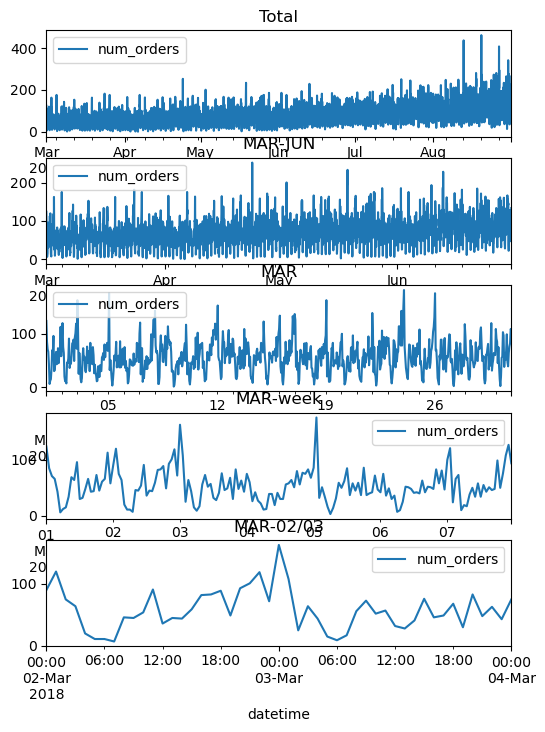

In [31]:
plt.figure(figsize=(6, 8))

plt.subplot(511)
data.plot(ax=plt.gca())
plt.title('Total')

plt.subplot(512)
data['2018-03':'2018-06'].plot(ax=plt.gca())
plt.title('MAR-JUN')

plt.subplot(513)
data['2018-03-01':'2018-03-30'].plot(ax=plt.gca())
plt.title('MAR')

plt.subplot(514)
data['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('MAR-week')

plt.subplot(515)
data['2018-03-02 00:00:00':'2018-03-04 00:00:00'].plot(ax=plt.gca())
plt.title('MAR-02/03')

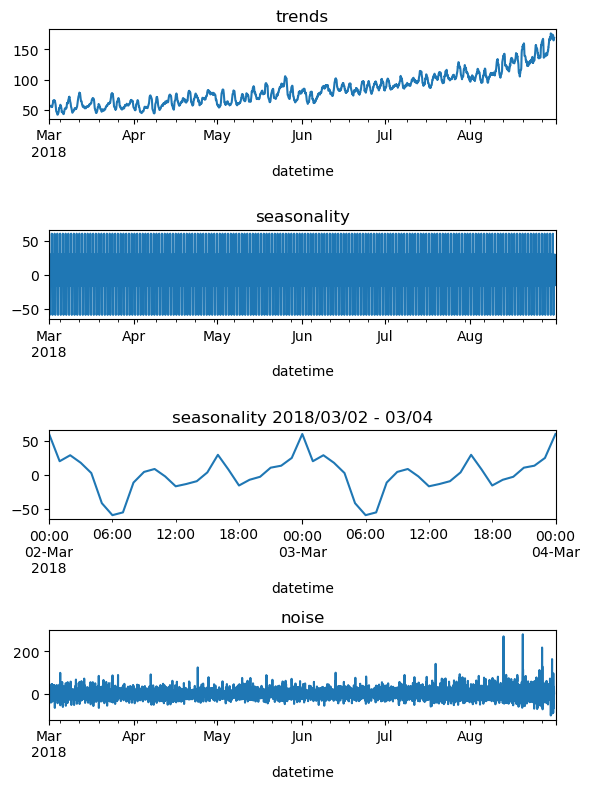

In [32]:
# trends, seasonality, and noise
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(6, 8))

plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('trends')

plt.subplot(412)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('seasonality')

plt.subplot(413)
decomposed.seasonal['2018-03-02 00:00:00':'2018-03-04 00:00:00'].plot(ax=plt.gca())
plt.title('seasonality 2018/03/02 - 03/04')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('noise')
plt.tight_layout()

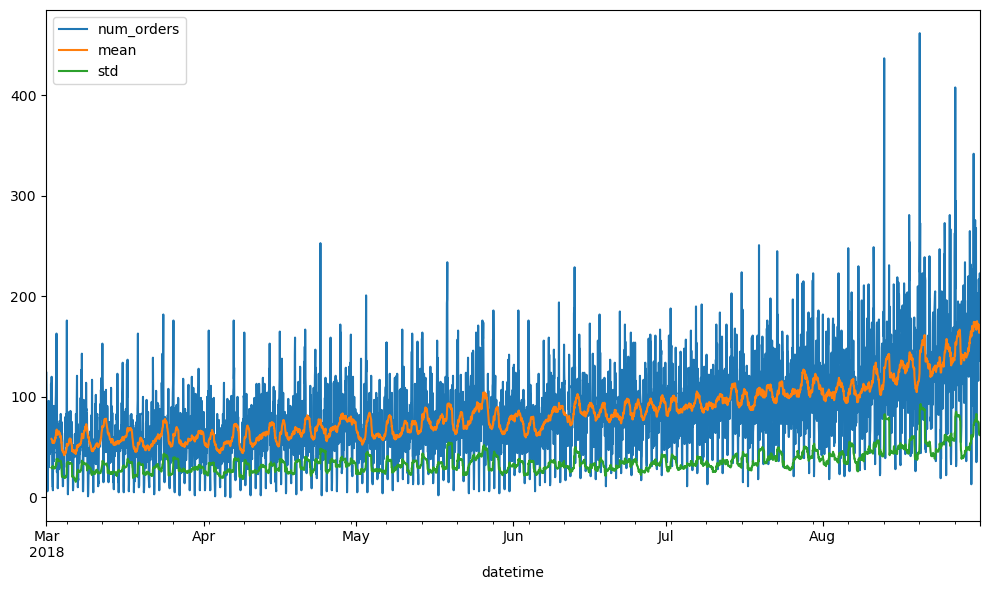

In [33]:
data['mean'] = data['num_orders'].rolling(25).mean()
data['std'] = data['num_orders'].rolling(25).std()

fig, ax = plt.subplots(figsize=(10, 6))

data[['num_orders', 'mean', 'std']].plot(ax=ax)

plt.tight_layout()
plt.show()
# cleaning columns with NaN for modeling
data = data.dropna(axis=1)

### conclusion:
- non-stationary process (increasing mean and also increasing standard deviation)
- upward trend until August (insufficient data to analyze annual seasonality)
- 
- August period with higher noise, which may affect the model...


## Treinamento## Training

### Creating Features:

In [34]:
# creating month, day, and day of the week
data.loc[:, 'month'] = data.index.month  # using .loc due to pandas warning
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour
# creating weekend flag
data['is_weekend'] = (data.index.dayofweek >= 5).astype(int)
# creating sinusoidal (cyclic) hours to approximate 23:00 and 00:00
data['sin_hour'] = np.sin(2 * np.pi * data.index.hour / 24)
data['cos_hour'] = np.cos(2 * np.pi * data.index.hour / 24)
# creating lags
max_lag = 4
for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
# rolling mean

rolling_mean_size = 4
data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

# removing NaN values from Shift commands
data = data.dropna(axis=0)


C:\Users\aswit\AppData\Local\Temp\ipykernel_10120\2164065168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'month'] = data.index.month  # using .loc due to pandas warning


<div class="alert alert-block alert-info">
<b>When using shuffle = false the model quality dropped significantly, so I created some more parameters:
    - weekend
    - sinusoidal (cyclic) hours.</b> <a class="tocSkip"></a>
</div>

### Creating train, test, and val sets

In [35]:
print(data.isna().sum())

num_orders      0
month           0
day             0
dayofweek       0
hour            0
is_weekend      0
sin_hour        0
cos_hour        0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
rolling_mean    0
dtype: int64


In [36]:
# Split the data into 90% train/validation and 10% test
train_data, test_data = train_test_split(data, test_size=0.1, random_state=54321, shuffle=False)
# Split the remaining 90% into train and validation
# (i.e., 60% train and 30% validation)
train_data, val_data = train_test_split(train_data, test_size=2/9, random_state=54321, shuffle=False)
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Training set
X_train = train_data.drop('num_orders', axis=1) 
y_train = train_data['num_orders']               
# Validation set
X_val = val_data.drop('num_orders', axis=1)
y_val = val_data['num_orders']
# Test set
X_test = test_data.drop('num_orders', axis=1)
y_test = test_data['num_orders']

Training set size: 3087
Validation set size: 883
Test set size: 442


### Logistic Regression

In [37]:
# scaling data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_val = scaler.transform(X_val)

In [38]:
model_lr = LogisticRegression(random_state=42, solver='liblinear')
model_lr.fit(X_train, y_train)

# Evaluating on the validation set

y_pred = model_lr.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE na validação: {rmse:.2f}")

RMSE na validação: 45.67


### Random Forest

In [39]:
best_depth = None
best_rmse = float('inf')

for depth in [5,10,15,20]:    
     model_fa = RandomForestClassifier(random_state=42,
                                       max_depth = depth
                                      )
        
     model_fa.fit(X_train, y_train)

     
    
     y_pred = model_fa.predict(X_val)
     rmse = np.sqrt(mean_squared_error(y_val, y_pred))
     print('depth:', depth, 'RMSE:',rmse)
     print()
    
     if rmse < best_rmse:
            best_depth = depth
            best_rmse = rmse
print('Best Depth .:', best_depth, 'RMSE:',best_rmse)

depth: 5 RMSE: 41.12283067491837

depth: 10 RMSE: 36.945921730318645

depth: 15 RMSE: 37.15996457422178

depth: 20 RMSE: 37.01802383076683

Best Depth .: 10 RMSE: 36.945921730318645


### LightGBM

In [40]:
from lightgbm import early_stopping
best_n_estimators = None
best_rmse = float('inf')

for n_estimators in [50,100,200,300]:    
     model_LGBMRegressor = lgb.LGBMRegressor(
     objective='regression',
     n_estimators=n_estimators,
     learning_rate=0.1,
     random_state=42,
     early_stopping_rounds=10
     )

     model_LGBMRegressor.fit(
         X_train, y_train,
         eval_set=[(X_val, y_val)],
         categorical_feature='auto',
         callbacks=[early_stopping(stopping_rounds=10)]
     )
    
     y_pred = model_LGBMRegressor.predict(X_val)
     rmse = np.sqrt(mean_squared_error(y_val, y_pred))
     print('n_estimators:', n_estimators, 'RMSE:',rmse)
     print()
    
     if rmse < best_rmse:
            best_n_estimators = n_estimators
            best_rmse = rmse
print('Best n .:', best_n_estimators, 'RMSE:',best_rmse)

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1033
[LightGBM] [Info] Number of data points in the train set: 3087, number of used features: 12
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Start training from score 70.613865
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's l2: 922.985
n_estimators: 50 RMSE: 30.380673156697036

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info

In [41]:
#model LGBMRegressor ,n_estimators=best_n_estimators,
model_LGBMRegressor = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=best_n_estimators,
    learning_rate=0.1,
    random_state=42
)

model_LGBMRegressor.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    categorical_feature='auto',
     callbacks=[early_stopping(stopping_rounds=10)]
)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1033
[LightGBM] [Info] Number of data points in the train set: 3087, number of used features: 12
[LightGBM] [Info] Start training from score 70.613865
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	valid_0's l2: 909.452


LGBMRegressor(objective='regression', random_state=42)

### Conclusion:
- Logistic regression showed RMSE on validation: 45.48  
- Random forest showed RMSE: 36.945921730318645
- LightGBM showed RMSE: 30.157124101512196

Thus, we can see that in the training and validation phase all models present RMSE below 48, with LightGBM showing the best result.


## Testing


### Logistic regression 

In [42]:
# testing model
y_pred = model_lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on test: {rmse:.2f}")


RMSE on test: 77.42


### Random Forest

In [43]:
model_rf = RandomForestClassifier(random_state=42, max_depth=best_depth)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on test: {rmse:.2f}")


RMSE on test: 67.01


### LightGBM

In [44]:

y_pred = model_LGBMRegressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on validation: {rmse:.2f}")


RMSE on validation: 55.44


## Conclusion


- best model LightGBM (RMSE on validation: 55.44)
